In [0]:
#ResNet Pythorch MNIST 2
cf.https://www.kaggle.com/readilen/resnet-for-mnist-with-pytorch


In [0]:
#ライブラリのインポート
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable

(1, 28, 28)


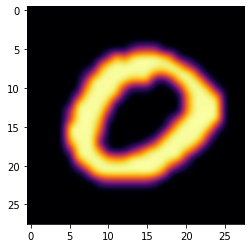

label: tensor(0)


In [10]:
data_folder = '~/data'

batch_size = 100
n_iters = 10000

#学習データ
train_data_with_labels = MNIST(data_folder, train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data_with_labels, batch_size=batch_size, shuffle=True)

#検証データ
test_data_with_labels = MNIST(data_folder, train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_data_with_labels, batch_size=batch_size, shuffle=True)

num_epochs = n_iters / (len(train_loader) / batch_size)
num_epochs = int(num_epochs)


data_iterator = iter(test_loader)
images, labels = data_iterator.next()
location=4
data = images[location].numpy()
print(data.shape)

reshaped_data = data.reshape(28,28)
plt.imshow(reshaped_data, cmap='inferno', interpolation='bicubic')
plt.show()
print('label:', labels[location])

In [0]:
# 3*3 convolutino
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)


# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [0]:
# batch_size, epoch and iteration
batch_size = 100
n_iters = 2500

#学習データ
train_data_with_labels = MNIST(data_folder, train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data_with_labels, batch_size=batch_size, shuffle=True)

#検証データ
test_data_with_labels = MNIST(data_folder, train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_data_with_labels, batch_size=batch_size, shuffle=True)

num_epochs = n_iters / (len(train_loader) / batch_size)
num_epochs = int(num_epochs)

# Create ResNet
net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2]
}
model = ResNet(**net_args)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# Adam Optimizer
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        train  = Variable(images.resize_(batch_size, 1, 32, 32))
        labels = Variable(labels)           
        # Clear gradients
        optimizer.zero_grad()    
        # Forward propagation
        outputs = model(train)        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)        
        # Calculating gradients
        loss.backward()        
        # Update parameters
        optimizer.step()        
        count += 1      
        if count % 250 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = Variable(images.resize_(batch_size, 1, 32, 32))                
                # Forward propagation
                outputs = model(images)                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]                
                # Total number of labels
                total += labels.size(0)              
                correct += (predicted == labels).sum()         
            accuracy = 100 * correct / float(total)           
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data.item(), accuracy))

Iteration: 500  Loss: nan  Accuracy: 9.800000190734863 %
Iteration: 1000  Loss: nan  Accuracy: 9.800000190734863 %
Iteration: 1500  Loss: nan  Accuracy: 9.800000190734863 %
Iteration: 2000  Loss: nan  Accuracy: 9.800000190734863 %
Iteration: 2500  Loss: nan  Accuracy: 9.800000190734863 %
Iteration: 3000  Loss: nan  Accuracy: 9.800000190734863 %
Iteration: 3500  Loss: nan  Accuracy: 9.800000190734863 %
Iteration: 4000  Loss: nan  Accuracy: 9.800000190734863 %
Iteration: 4500  Loss: nan  Accuracy: 9.800000190734863 %
Iteration: 5000  Loss: nan  Accuracy: 9.800000190734863 %
Iteration: 5500  Loss: nan  Accuracy: 9.800000190734863 %
Iteration: 6000  Loss: nan  Accuracy: 9.800000190734863 %
Iteration: 6500  Loss: nan  Accuracy: 9.800000190734863 %


KeyboardInterrupt: ignored